# Imports

In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import math
import os 
import re
import pandas as pd
import sys
import seaborn as sns
import re
# must make changes to the databaseMaker.py file, not the notebook (.ipynb) file.
from databaseMaker import create
from scipy.optimize import minimize
from multiprocessing import Pool, cpu_count

# Create pandas dataframe of the data

In [ ]:
dfDict, backDict = create()

# Fit each lineout to a tilted gaussian, create a new dataframe from the fit parameters

In [3]:
pool=Pool(processes=cpu_count())
print(pool)
lineDict = {}
fitDict = {}
# parameterList=[]
savepath='C:/Users/wahlm/OneDrive/Documents/School/Research/ARP/PubFigs/'
baseline=506
conversion=17.45138889
k=5.79988*10**6/(2*np.pi)

            
for k1,v1 in dfDict.items():
    for k2,v2 in v1.items():
        try:
            lineDict[k1][k2]=pd.DataFrame()
            lineDict[k1][k2]['max']=dfDict[k1][k2].idxmax()
            lineDict[k1][k2]['detuning']=lineDict[k1][k2].index.tolist()
        except:
            lineDict[k1]={}
            lineDict[k1][k2]=pd.DataFrame()
            lineDict[k1][k2]['max']=dfDict[k1][k2].idxmax()
            lineDict[k1][k2]['detuning']=lineDict[k1][k2].index.tolist()



# B array:
# 0: main "peak"
# 1: main width
# 2: main x coefficient
# 3: main untilted coefficient
            
def uglyFun(x,B):
    main=(np.multiply(B[2],x-B[0])+B[3])*np.exp(-(x-B[0])**2/(2*B[1]**2))
    return main




def uglyChi2(B, args):
    chi2=0
# no uncertainties in raw data
    return chi2 + np.sum((uglyFun(args[0],B)-args[1])**2)

def fitLineout(params):
    k1=params[0]
    v1=params[1]
    k2=params[2]
    v2=params[3]

    try:
        fitDict[k1][k2]=pd.DataFrame()
    except:
        fitDict[k1]={}
        fitDict[k1][k2]=pd.DataFrame()
    for detun in dfDict[k1][k2].columns:


        xData=dfDict[k1][k2].index.tolist()[:baseline+25]
        yData=dfDict[k1][k2][detun].tolist()[:baseline+25]

        #approx peak
        peakApp=dfDict[k1][k2][detun].idxmax()
        ampApp=dfDict[k1][k2][detun].max()
        #approx fwhm
        fwhmX=[xval for index, xval in enumerate(xData) if yData[index]>.5*ampApp]
        fwhmApp=max(fwhmX)-min(fwhmX)

        #fit parameters
        guess = [peakApp, fwhmApp/2.355,-.005,ampApp]
        bounds = [(guess[0]-75,guess[0]+75),(.9*guess[1],1.5*guess[1]),(-.01,0),(0,2*guess[3])] 

        result=minimize(uglyChi2, guess, bounds = bounds, args=([xData,yData]),options={'disp':True})
        if result.x[2]==0:
            peak=result.x[0]
        else:
            peak=(2*result.x[0]*result.x[2]-result.x[3]+(4*result.x[1]**2*result.x[2]**2+result.x[3]**2)**.5)/(2*result.x[2])
            
        #Fix coefficients + s/n
        signal=uglyFun(peak,result.x)
        noise=np.sqrt(uglyChi2(result.x,[xData,yData])/len(xData))

#         plusErr=0
#         minErr=0

        #exact fwhm
        cutoff=.5*(signal)
        sampleX=np.linspace(0,xData[-1],1000)
        sampleY=uglyFun(sampleX,result.x)
        fwhmX=[xval for index, xval in enumerate(sampleX) if sampleY[index]>cutoff]
        plusErr=max(fwhmX)-peak
        minErr=min(fwhmX)-peak

#             print(noise/signal)
        fitDict[k1][k2]=pd.concat([fitDict[k1][k2],
            pd.DataFrame({
            'peak':peak,
            'posunc':-minErr/conversion*noise/signal,
            'negunc':-plusErr/conversion*noise/signal,
            'detuning':detun,
            'height':(baseline-peak)/conversion,
            'velocity':detun*10**6/k
            }, index=[0])], 
                ignore_index=True)
#             For checking my fitting work
#         if uglyChi2(result.x,[xData,yData])/(len(xData))>2:
#         if True:
        if False:
            f, ax=plt.subplots(1,1)
            plt.scatter(dfDict[k1][k2].index.tolist(),dfDict[k1][k2][detun], alpha = .4)
#                 plt.axvline(x=peak,color='k')
            plt.scatter(peak,uglyFun(peak,result.x),color='k')
            xaxs= np.linspace(min(xData),max(xData),1000)
            plt.plot(xaxs,uglyFun(xaxs,result.x),'r-')
            ax.set_ylabel('Intensity')
            ax.set_xlabel('Pixel')
#             plt.hlines(cutoff, int(peak)+2*minErr, int(peak)+2*plusErr,colors='k')
            plt.show()
#             f.savefig(savepath+f'{k1}sweep{k2}pp{-detun*10**6/k:.0f}mps.png', dpi=300,bbox_inches='tight', format='png')
            print(f'{k1} sweep, {k2} pulse pairs, {detun} detuning, {detun*10**6/k} m/s')
            print(result.message)
            print(f'Chisquare: {uglyChi2(result.x,[xData,yData])}')
#                 print(f'+Error: {plusErr}, -Error: {minErr}')
            print(f'Peak: {peak}')
            print(f'Pos unc: {-minErr/conversion*noise/signal}')
            print(f'Neg unc: {-plusErr/conversion*noise/signal}')
            print(result.x)
        
        
        
for k1,v1 in dfDict.items():
    for k2,v2 in v1.items():
        #begin pool work
        pool.apply_async(fitLineout((k1,v1,k2,v2)))

pool.close()
pool.terminate()
            
 


<multiprocessing.pool.Pool state=RUN pool_size=12>


# Lineout peak vs. Doppler velocity plots (separate axes)

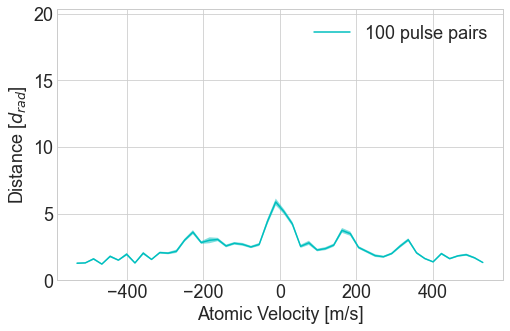

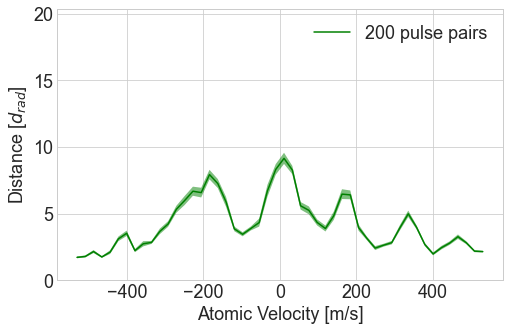

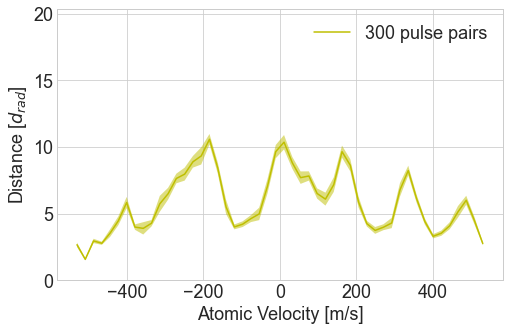

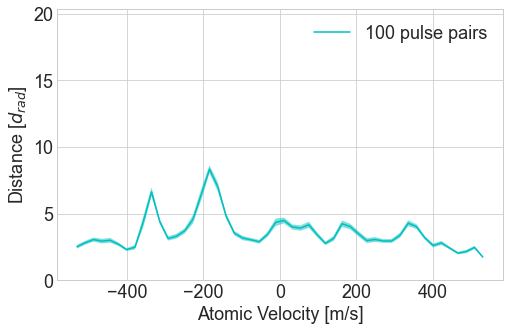

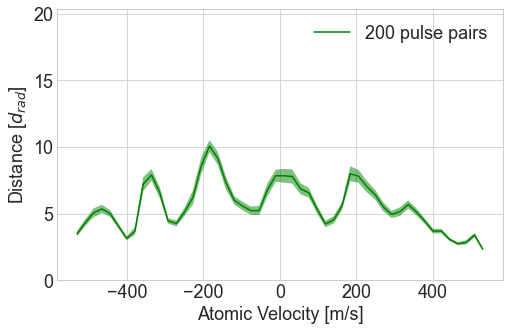

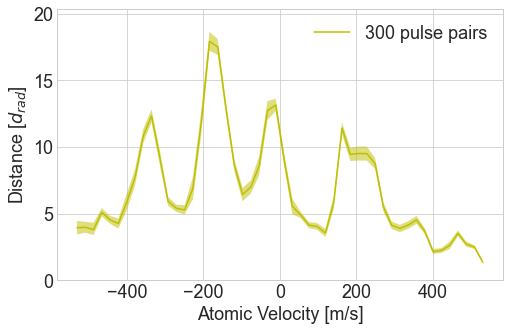

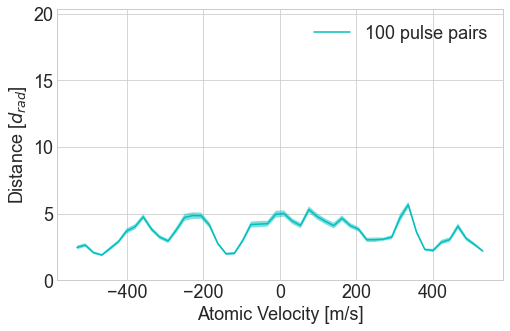

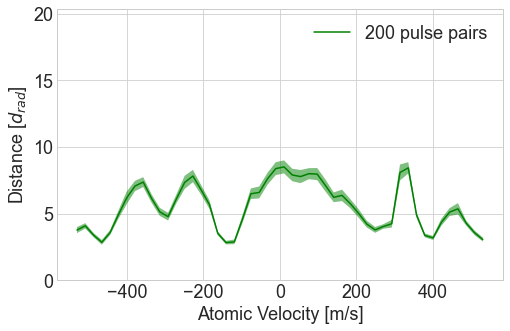

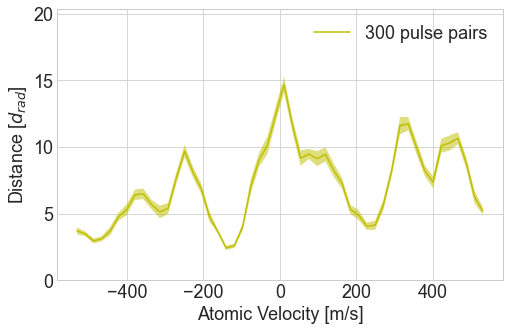

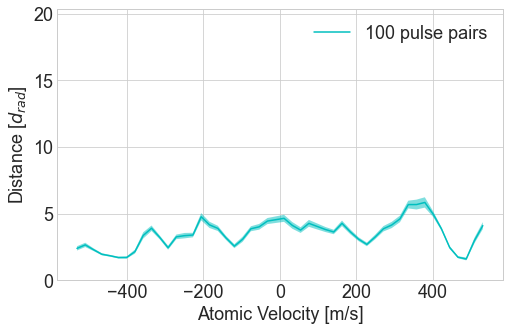

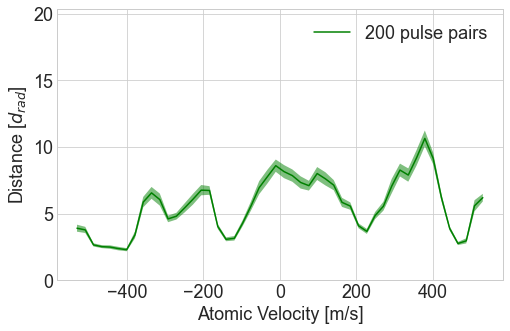

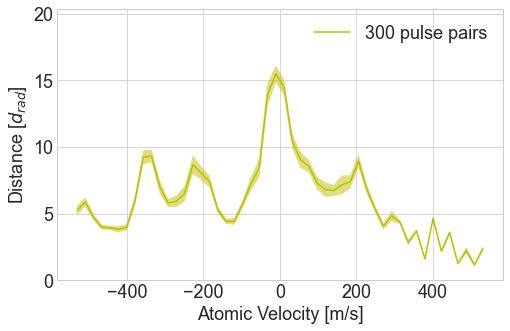

In [17]:
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=18)

path='C:/Users/wahlm/OneDrive/Documents/School/Research/ARP/PubFigs/'
pps=['100','200','300']
colors=['c','g','y','r']
for sweep in ['downdown','downup','updown','upup']:

#     f, axs= plt.subplots(4,2,figsize=(16,20))
#     f.suptitle(f'{sweep} sweep',fontsize=20)

    for num, pp in enumerate(pps):
        savepath=path+f'{sweep}_{pp}_lineplot.png'
        f, axs= plt.subplots(1,1,figsize=(8,5))

        sns.lineplot(x='velocity',y='height',data=fitDict[sweep][pp], color=colors[num],label=f'{pp} pulse pairs',ax=axs)
        axs.set_ylabel(r'Distance [$d_{rad}$]')
        
        axs.set_xlabel(r'Atomic Velocity [m/s]')

        axs.set_ylim([0,(baseline-150)/conversion])
#         axs.set_title(f'{sweep} sweep, {pp} pulse pairs')

        x=fitDict[sweep][pp]['velocity']
        y=fitDict[sweep][pp]['height']
        ypluserr=fitDict[sweep][pp]['posunc']
        ynegerr=fitDict[sweep][pp]['negunc']
#       pos/neg flipped 
        axs.fill_between(x, y+ynegerr, y+ypluserr,facecolor=colors[num],alpha=0.5)
        f.savefig(savepath, dpi=300,bbox_inches='tight', format='png')
        plt.show()




# Lineout peak vs. Doppler velocity plots (overlayed, grouped by sweep dir.)

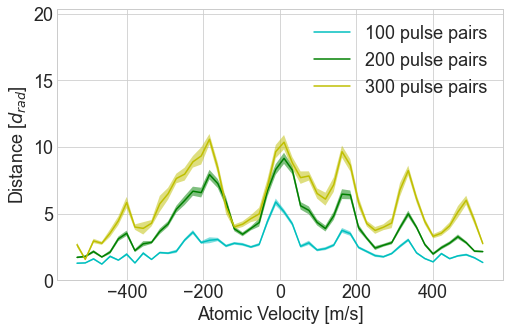

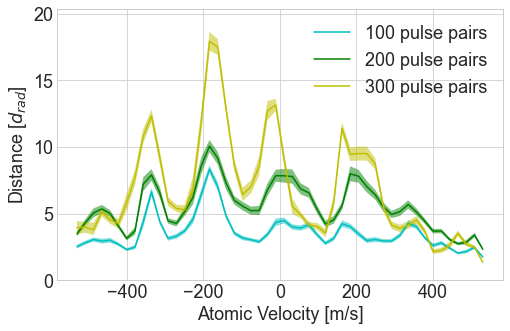

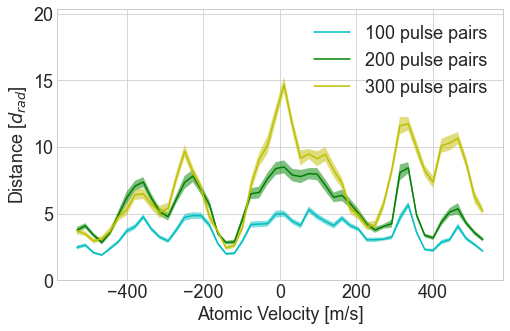

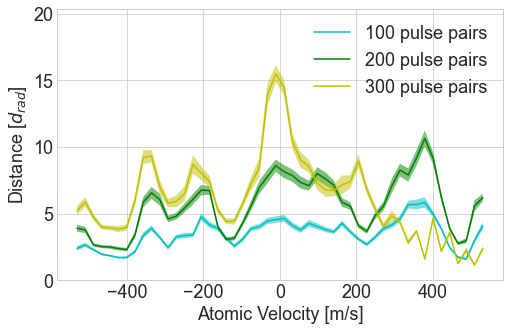

In [28]:
pps=['100','200','300']
colors=['c','g','y','r']
for sweep in ['downdown','downup','updown','upup']:
    f, axs= plt.subplots(1,1,figsize=(8,5))
    for num, pp in enumerate(pps):
        savepath=path+f'{sweep}_overlay_lineplot_tiltedgaus.png'
        sns.lineplot(x=fitDict[sweep][pp]['velocity'],y=fitDict[sweep][pp]['height'],color=colors[num],label=f'{pp} pulse pairs',ax=axs)
        x=fitDict[sweep][pp]['velocity']
        y=fitDict[sweep][pp]['height']
        ypluserr=fitDict[sweep][pp]['posunc']
        ynegerr=fitDict[sweep][pp]['negunc']
        axs.fill_between(x, y+ynegerr, y+ypluserr,facecolor=colors[num],alpha=0.5)
#     axs.invert_xaxis()
    axs.set_ylabel(r'Distance [$d_{rad}$]')
#     axs.set_title(f'{sweep} sweep')

    axs.set_xlabel(r'Atomic Velocity [m/s]')

    axs.set_ylim([0,(baseline-150)/conversion])
    plt.show()

    
    f.savefig(savepath, dpi=300,bbox_inches='tight', format='png')
#     plt.show()

#     for num, pp in enumerate(pps):

#         savepath=path+f'{sweep}_{pp}_heatmap.png'
#         f, axs= plt.subplots(1,1,figsize=(8,5))

#         tickspace=['' for i in range(11)]
#         xlabel = ['-530']+tickspace+['-265']+tickspace+['0']+tickspace+['','265']+tickspace+['530']
#         tickspace=['' for i in range(25)]
#         ylabel= np.linspace(baseline/conversion,(baseline-len(dfDict[sweep][pp]))/conversion,len(dfDict[sweep][pp])).tolist()
#         for i,x in enumerate(ylabel):
#             if x%5<0.055:
#                 ylabel[i]=round(x)
#             else:
#                 ylabel[i]=''
#         sns.heatmap(dfDict[sweep][pp], xticklabels=xlabel,yticklabels=ylabel,vmin=0, vmax = dfDict[sweep]['300'].max().max(),cmap=sns.color_palette("magma", as_cmap=True),cbar=False, ax=axs)
        
#         axs.set_ylim([baseline,150])
# #         axs.set_ylim([0,(baseline-150)/conversion])
#         axs.set_ylabel(r'Distance [$d_{rad}$]')
#         axs.set_yticklabels(ylabel)
#         axs.set_xlabel(r'Atomic Velocity [m/s]')
# #         f.savefig(savepath, dpi=300,bbox_inches='tight', format='png')        
#         plt.show()



# Heatmap Plots

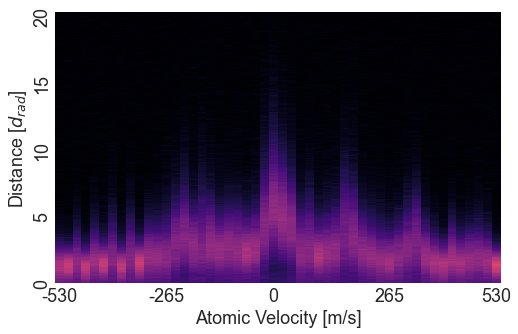

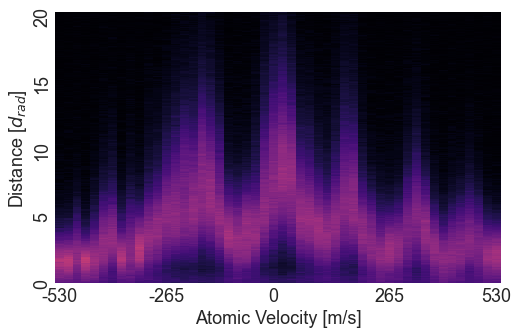

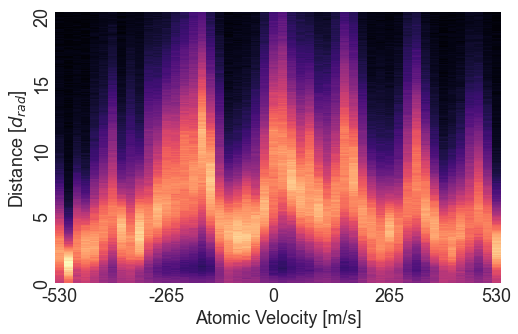

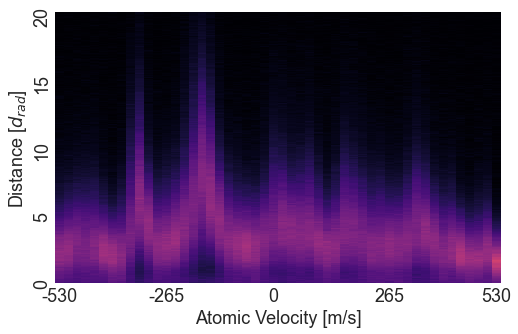

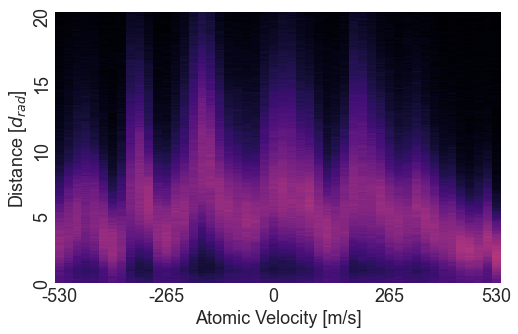

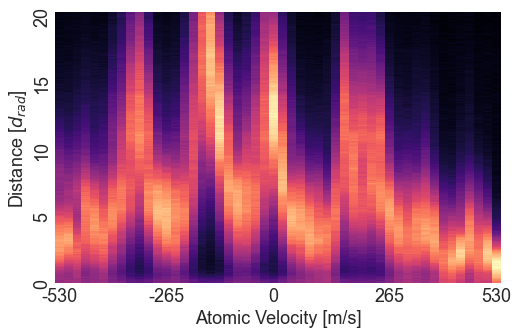

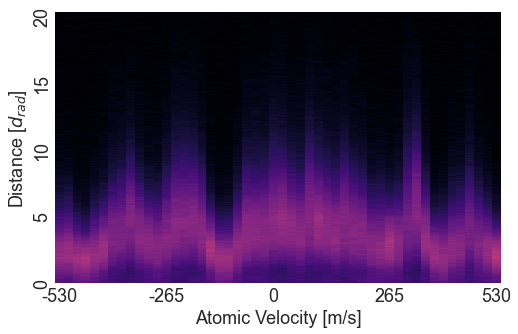

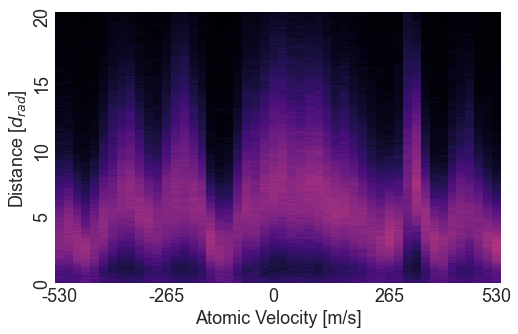

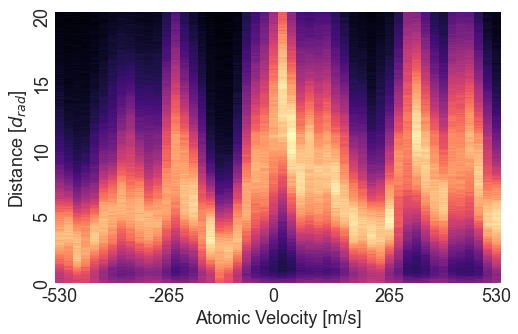

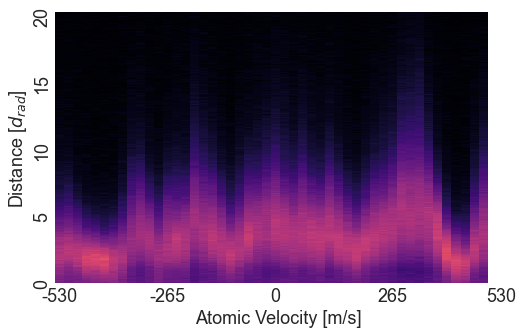

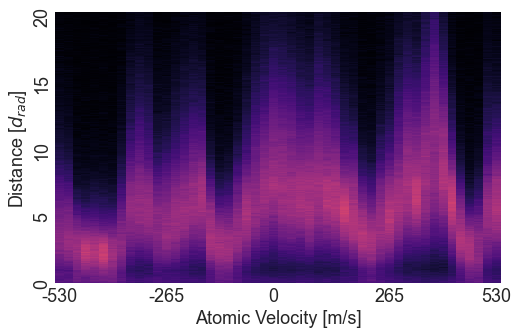

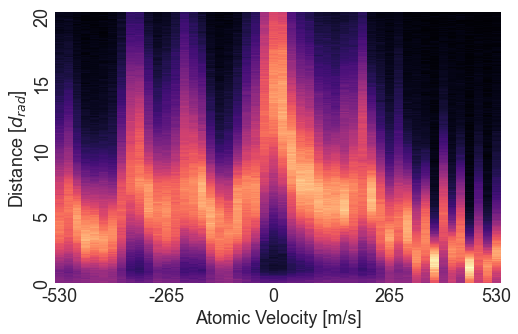

In [18]:
for sweep in ['downdown','downup','updown','upup']:
    for num, pp in enumerate(['100','200','300']):
        savepath=path+f'{sweep}_{pp}_heatmap.png'
        f, axs= plt.subplots(1,1,figsize=(8,5))

        tickspace=['' for i in range(11)]
        xlabel = ['-530']+tickspace+['-265']+tickspace+['0']+tickspace+['','265']+tickspace+['530']
        tickspace=['' for i in range(25)]
#         print(len(dfDict[sweep][pp]))
        ylabel= np.linspace(baseline/conversion,(baseline-len(dfDict[sweep][pp]))/conversion,len(dfDict[sweep][pp])).tolist()
        for i,x in enumerate(ylabel):
            if x%5<0.055:
                ylabel[i]=round(x)
            else:
                ylabel[i]=''
        sns.heatmap(dfDict[sweep][pp], xticklabels=xlabel,yticklabels=ylabel,vmin=0, vmax = dfDict[sweep]['300'].max().max(),cmap=sns.color_palette("magma", as_cmap=True),cbar=False, ax=axs)
        
        axs.set_ylim([baseline,150])
#         axs.set_ylim([0,(baseline-150)/conversion])
        axs.set_ylabel(r'Distance [$d_{rad}$]')
        axs.set_yticklabels(ylabel)
        axs.set_xlabel(r'Atomic Velocity [m/s]')
#         f.savefig(savepath, dpi=300,bbox_inches='tight', format='png')        
        plt.show()
#     axs[0][0].title.set_text('1')
#     axs[1][0].title.set_text('2')
#     axs[2][0].title.set_text('3')
#     axs[3][0].title.set_text('a')
    
#     axs[0][1].title.set_text('4')
#     axs[1][1].title.set_text('5')
#     axs[2][1].title.set_text('6')
#     axs[3][1].title.set_text('b')
#     plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.15, 
#                     hspace=0.3)
#     plt.show()
    
#     f.savefig(savepath, dpi=300,bbox_inches='tight', format='png')

# Characterize lineout peaks

In [19]:
ranges={'downdown':[(-250,-150),(-30,30),(110,190),(250,370)], 
       'downup':[(-390,-250),(-210,110),(-50,50),(110,210),(290,390)],
       'updown':[(-390,-290),(-290,-150),(-30,30),(50,110),(250,370),(370,490)],
       'upup':[(-390,-250),(-250,-150),(-30,30)]}
peaks={}
for sweep in ['downdown','downup','updown','upup']:
    peaks[sweep]={}
    for num, pp in enumerate(['100','200','300']):
        peaks[sweep][pp]=[]
        for a,b in ranges[sweep]:
            cut=fitDict[sweep][pp].loc[(a<=fitDict[sweep][pp]['detuning'])&(b>=fitDict[sweep][pp]['detuning'])]
            peakrow=cut[cut.height==cut.height.max()]
            peaks[sweep][pp].append((int(peakrow['detuning']),float(peakrow['height'])))
            
# print(peaks['updown'])

In [20]:
pspacings={}
pheights={}
for sweep in ['downdown','downup','updown','upup']:
    pspacings[sweep]={}
    pheights[sweep]={}

    for pp in ['100','200','300']:
        spacing=[]
        height=[]
        for d,h in peaks[sweep][pp]:
            spacing.append(d)
            height.append(h)
        
        spacelist=[]
        for i in range(len(spacing)-1):
            spacelist.append(spacing[i+1]-spacing[i])
                                     
        pspacings[sweep][pp]=spacelist
        pheights[sweep][pp]=height

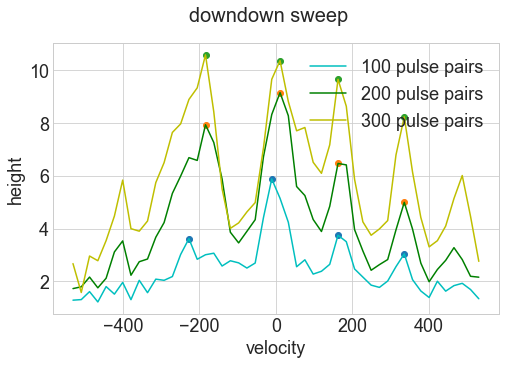

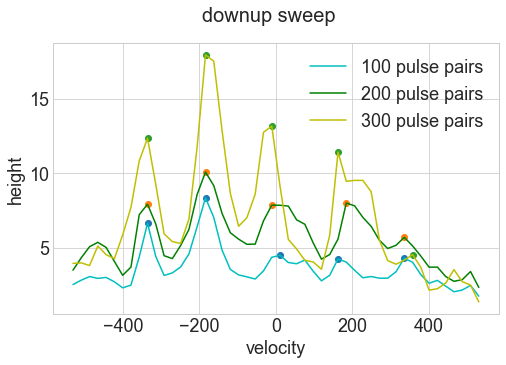

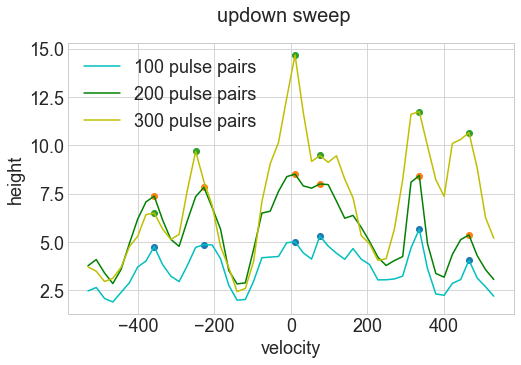

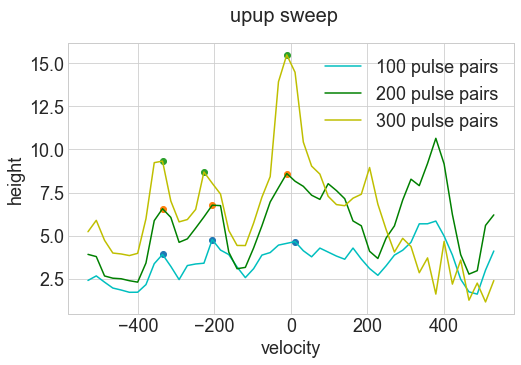

In [21]:
plt.style.use('seaborn-whitegrid')
for i,sweep in enumerate(['downdown','downup','updown','upup']):
    
    pps=['100','200','300']
    colors=['c','g','y','r']
    f, axs= plt.subplots(1,1,figsize=(8,5))
    f.suptitle(f'{sweep} sweep',fontsize=20)

    for num, pp in enumerate(pps):
        sns.lineplot(x='velocity',y='height',data=fitDict[sweep][pp], color=colors[num],label=f'{pp} pulse pairs',ax=axs)
        axs.scatter([loc*10**6/k for loc, hgt in peaks[sweep][pp]],[hgt for loc, hgt in peaks[sweep][pp]])



    plt.show()


178.1476370512223 19.85193309503752


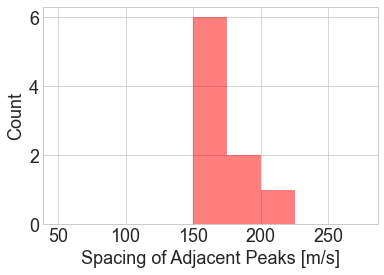

169.7217352987996 17.31823081568767


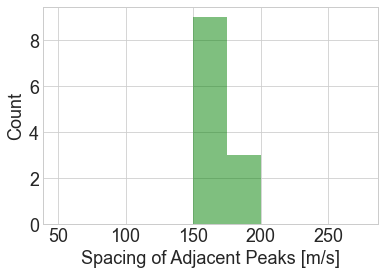

164.666194247346 75.80215716027841


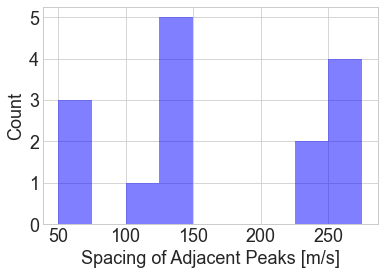

166.11063454776132 44.520640071664445


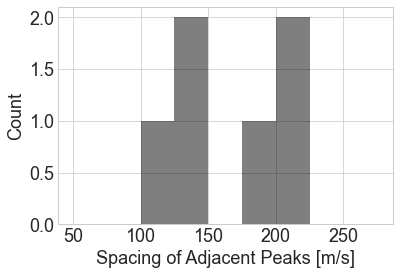

In [22]:
# f, ax =plt.subplots()
colors=['r','g','b','k']
for i, sweep in enumerate(['downdown','downup','updown','upup']):
    histarr=[]
    savepath=path+sweep+'spacing.png'
    for pp in ['100','200','300']:
        histarr+=pspacings[sweep][pp]
        
    histarr=np.array(histarr)/k*10**6
    print(np.mean(histarr),np.std(histarr))
    f, ax =plt.subplots()
    binning=[x for x in range(50,300,25)]
#     ax.hist(histarr, bins=binning, histtype='barstacked', color=colors[i], alpha=.5, label=f'{sweep} Sweep')
    ax.hist(histarr, bins=binning, histtype='barstacked', color=colors[i], alpha=.5)
    ax.set_xlabel('Spacing of Adjacent Peaks [m/s]')
    ax.set_ylabel('Count')
#     ax.legend(loc='upper left')
    f.savefig(savepath, dpi=300,bbox_inches='tight', format='png')
    plt.show()

35
167.76142346252166 34.098132955247465


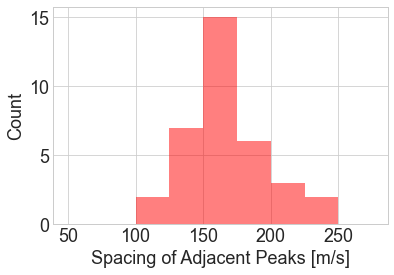

In [24]:
f, ax =plt.subplots()
colors=['r','g','b','k']
histarr=[]
savepath=path+'totalspacing.png'
for i, sweep in enumerate(['downdown','downup','updown','upup']):

    
    for pp in ['100','200','300']:
        histarr+=pspacings[sweep][pp]
mx=max(histarr)
mn=min(histarr)
histarr=[i for i in histarr if i!=mx and i!= mn]
print(len(histarr))
histarr=np.array(histarr)/k*10**6


print(np.mean(histarr),np.std(histarr))

#     f, ax =plt.subplots()
binning=[x for x in range(50,300,25)]
#     ax.hist(histarr, bins=binning, histtype='barstacked', color=colors[i], alpha=.5, label=f'{sweep} Sweep')
ax.hist(histarr, bins=binning, histtype='barstacked', color=colors[0], alpha=.5)
ax.set_xlabel('Spacing of Adjacent Peaks [m/s]')
ax.set_ylabel('Count')
#     ax.legend(loc='upper left')
# ax.title.set_text('c')
f.savefig(savepath, dpi=1000,bbox_inches='tight', format='png')

In [26]:
# colors=['r','g','b','k']
# histdict={}

# for i, sweep in enumerate(['downdown','downup','updown','upup']):
#     stdev=0
#     histdict[sweep]=np.zeros()
#     for pp in ['100','200','300']:
#         for h in pheights[sweep][pp]:
            
#         histdict{sweep}+=pheights[sweep][pp]
colors=['r','g','b','k']
histdict={}
meanheights={}

for i, sweep in enumerate(['downdown','downup','updown','upup']):
    meanheights[sweep]={}
    for pp in ['100','200','300']:
        harr=np.array(pheights[sweep][pp])
        meanheights[sweep][pp]=(np.mean(harr),np.std(harr))

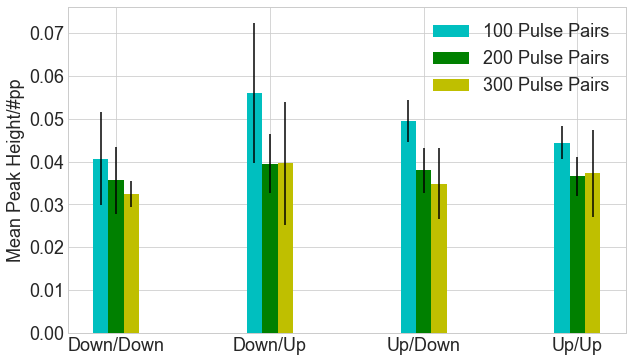

In [27]:
plt.style.use('seaborn-whitegrid')
pps=['100','200','300']
colors=['c','g','y','r']
f, axs= plt.subplots(1,1,figsize=(10,6))
# f.suptitle('Normalized Mean Peak Height by Sweep Direction and Pulse Pair',fontsize=20)

x = np.arange(4)
xlabel=['Down/Down','Down/Up','Up/Down','Up/Up']
barwidth=.1
for num, pp in enumerate(pps):
    y=[]
    err=[]
    for sweep in ['downdown','downup','updown','upup']:       
        y.append(meanheights[sweep][pp][0]/float(pp))
        err.append(meanheights[sweep][pp][1]/float(pp))
            
    axs.bar(x + num*barwidth, y,yerr=err,width=barwidth,color=colors[num],
           label=f'{pp} Pulse Pairs')

axs.legend(loc='upper right')
axs.set_xticks(x + barwidth)
axs.set_xticklabels(xlabel) 
axs.set_ylabel('Mean Peak Height/#pp')  
f.savefig(path+'peakheight.png', dpi=1000,bbox_inches='tight', format='png')
plt.show()

# Messing with organization

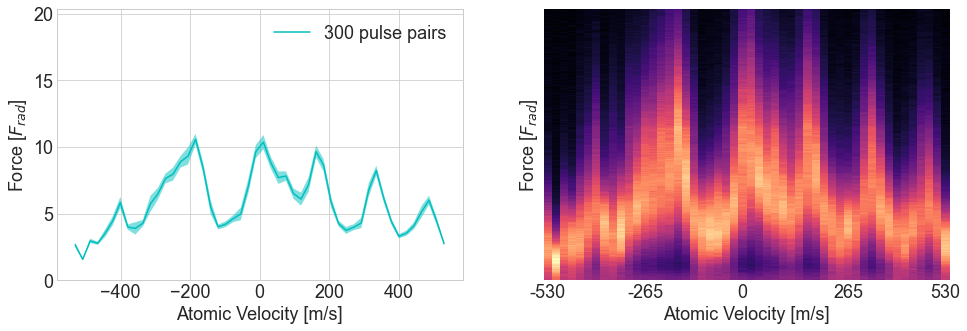

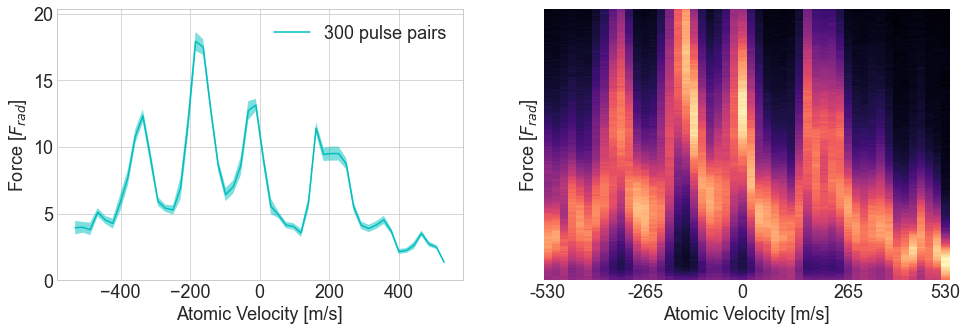

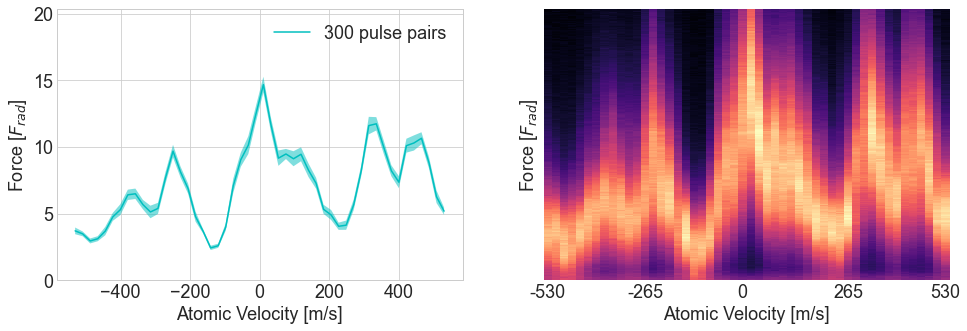

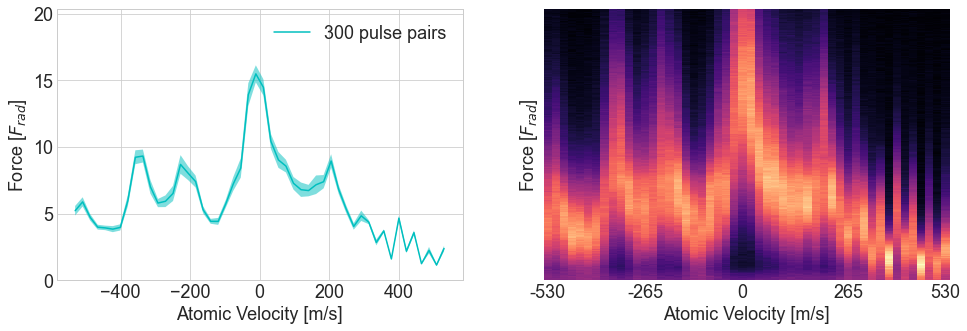

In [9]:
plt.style.use('seaborn-whitegrid')
pps=['300']
colors=['c','g','y','r']

# f, axs= plt.subplots(1,2,figsize=(8,5))
# sns.lineplot(x='velocity',y='height',data=fitDict[sweep][pp], color=colors[num],label=f'{pp} pulse pairs',ax=axs)
# axs.set_ylabel(r'Force [$F_{rad}$]')

for sweep in ['downdown','downup','updown','upup']:
    savepath=path+sweep+'sing.png'

    f, axs= plt.subplots(1,2,figsize=(16,5))
#     f.suptitle(f'{sweep} sweep',fontsize=20)

    for num, pp in enumerate(pps):
        sns.lineplot(x='velocity',y='height',data=fitDict[sweep][pp], color=colors[num],label=f'{pp} pulse pairs',ax=axs[0])
#         sns.lineplot(x='velocity',y='height',data=fitDict[sweep][pp], color=colors[num],label=f'{pp} pulse pairs',ax=axs[0][1])
        axs[0].set_ylabel(r'Force [$F_{rad}$]')
        
        axs[0].set_xlabel(r'Atomic Velocity [m/s]')

        
        axs[0].set_ylim([0,(baseline-150)/conversion])
#         axs[0][1].set_ylim([0,(baseline-150)/conversion])
        x=fitDict[sweep][pp]['velocity']
        y=fitDict[sweep][pp]['height']
        ypluserr=fitDict[sweep][pp]['posunc']
        ynegerr=fitDict[sweep][pp]['negunc']
        axs[0].fill_between(x, y+ynegerr, y+ypluserr,facecolor=colors[num],alpha=0.5)

    for num, pp in enumerate(pps):
#         sns.lineplot(x='velocity',y='height',data=fitDict[sweep][pp], color=colors[num],label=f'{pp} pulse pairs',ax=axs[num+1][0])

#         x=fitDict[sweep][pp]['velocity']
#         y=fitDict[sweep][pp]['height']
#         ypluserr=fitDict[sweep][pp]['posunc']
#         ynegerr=fitDict[sweep][pp]['negunc']
#         axs[num+1][0].fill_between(x, y+ynegerr, y+ypluserr,facecolor=colors[num],alpha=0.5)

        
        tickspace=['' for i in range(11)]
        xlabel = ['-530']+tickspace+['-265']+tickspace+['0']+tickspace+['','265']+tickspace+['530']

        sns.heatmap(dfDict[sweep][pp], xticklabels=xlabel,vmin=0, vmax = dfDict[sweep]['300'].max().max(),cmap=sns.color_palette("magma", as_cmap=True),yticklabels=False,cbar=False, ax=axs[1])
        
        axs[1].set_ylim([baseline,150])
#         axs[num+1][0].set_ylim([0,(baseline-150)/conversion])
#         axs[num+1][0].set_ylabel(r'Force [$F_{rad}$]')
        axs[1].set_ylabel(r'Force [$F_{rad}$]')
        axs[1].set_xlabel(r'Atomic Velocity [m/s]')
#         axs[num+1][1].set_xlabel(r'Atomic Velocity [m/s]')

    plt.show()
#     f.savefig(savepath, dpi=200,bbox_inches='tight', format='png')
